# Identify the candidate blooming bacteria

The goal of this notebook is to identify candidate bacteria which bloom under shipping conditions. We identified cadnidates in two parts: first, we looked for bacteria which grew at room temperature in storage studies. We also looked at shipped American Gut samples and compared them to fresh frozen fecal samples. We used the combined technique because the storage studies were limited by size, while the comparison between studies is noisy.

Briefly, this process will involve the following steps:

1. Load the datasets (Mayo and Se-Jin storage studies and AG, PGP, UK-Twins and Whole grain feces)
2. Calculate the fold change per sOTU in the storage studies
3. Calculate the fold change in AG compared to fresh frozen studies (PGP, UK-Twins and Whole grain feces)
4. Identify candidate blooming bacteria by combining the fold changes in 2,3
5. Plot the scatter of the fold change per sOTU with highlighting the candidate blooming bacteria
6. Plot taxonomy plots before and after bloom filtering

Let's start by loading the necessary python functions. 

In [1]:
# plots inside the notebook
%matplotlib notebook

# load modules used in the analysis
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
# heatsequer module is available from:
# https://github.com/amnona/heatsequer
import heatsequer as hs

# set the random seed
np.random.seed(2016)

/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new 

('loading cooldb',)
('cooldb loaded',)
('loading bactdb',)
('bactdb loaded',)
('loading supercooldb',)
('supercooldb loaded',)


Sets up the display to full width of browser

In [2]:
# set display to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loading all experimental data

## Song fecal stability study
Data from:

Song, Se Jin, et al. "Preservation Methods Differ in Fecal Microbiome Stability, Affecting Suitability for Field Studies." mSystems 1.3 (2016): e00021-16.

This study compares the stability of human and dog fecal samples under a variety of storage conditions.

We will only use samples with no preservative stored at ambient temperature for 7, 14 and 28 days (compared to samples sequenced at day 0)

In [3]:
# load se jin storage study
sj=hs.load('../data/storage.sejin.new.clean.withtax.biom','../data/map.storage.sejin.txt')

# and keep only RT no preservative
# get no preservative
sjf=hs.filtersamples(sj,'preservative','None')
# and only room temp
sjf=hs.filtersamples(sjf,'temperature','amb')
# keep only samples with >1000 reads
sjf=hs.filterorigreads(sjf,1000)

('Loading biom table ../data/storage.sejin.new.clean.withtax.biom',)
87637faf6ddbfb5946c42c5989054cb3
('Loading mapping file ../data/map.storage.sejin.txt',)
('number of samples in map is 1142',)
('number of samples in table is 1141',)
('removing 0 samples',)
('deleted. number of samples in table is now 1141',)
('removing 1 samples from mapping file',)
('number of samples in mapping file is now 1141',)
('220 Samples left',)
('75 Samples left',)
('75 Samples left',)


The sample is filtered to only include perservative-free samples stored at room temperature. These include samples collected at day 0 and immediately sequenced, which we use as a reference. We will only use samples with at least 1000 sequences.

## Mayo fecal stability study

Data from:

Sinha, Rashmi, et al. "Collecting fecal samples for microbiome analyses in epidemiology studies." Cancer Epidemiology Biomarkers & Prevention 25.2 (2016): 407-416.

This study compares the effect of different storage conditions on human fecal samples.

We will use only samples stored without a perservative. The samples were stored at room temperature for 1, and 4 days and compared to samples frozen at time 0. Again, we will only use samples with at least 1000 sequences.

In [4]:
mayo=hs.load('../data/mayo.new.min10.clean.withtax.biom','../data/map.mayo1.txt')

# only no treatment
mayof=hs.filtersamples(mayo,'TREATMENT','No Additive')

# keep only samples with >1000 reads
mayof=hs.filterorigreads(mayof,1000)

('Loading biom table ../data/mayo.new.min10.clean.withtax.biom',)
acbfaf6d2e684236fb7a5dca190c212e
('Loading mapping file ../data/map.mayo1.txt',)
('number of samples in map is 960',)
('number of samples in table is 958',)
('removing 0 samples',)
('deleted. number of samples in table is now 958',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 958',)
('Samples with 0 reads: 18',)
('252 Samples left',)
('242 Samples left',)


## American Gut

The [American Gut Project](<http://www.americangut.org>) is a cross sectional study. Samples were shipped through local post without perservatives. We will use only fecal samples with at least 1000 sequences per sample.

In [5]:
ag=hs.load('../data/ag-6-2016.clean.min100.withtax.biom','../data/map.ag-6-2016.txt')

# get only fecal
agf=hs.filtersamples(ag,'ENV_MATTER','ENVO:feces')

# convert date to number
agf=hs.convertdatefield(agf,'COLLECTION_DATE','date-numeric','%m/%d/%Y')

# and sort by collection date
agf=hs.sortsamples(agf,'date-numeric',numeric=True)

# keep only samples with >1000 reads
agf=hs.filterorigreads(agf,1000)

('Loading biom table ../data/ag-6-2016.clean.min100.withtax.biom',)
5ffd56560ea3217b52a6076d5dd5d2f6
('Loading mapping file ../data/map.ag-6-2016.txt',)
('number of samples in map is 9919',)
('number of samples in table is 9919',)
('removing 0 samples',)
('deleted. number of samples in table is now 9919',)
('number of samples in mapping file is now 9919',)
('Samples with 0 reads: 1214',)
('7286 Samples left',)
('1 conversions failed',)
('7073 Samples left',)


## UK twins study
Data from:

Goodrich, Julia K., et al. "Human genetics shape the gut microbiome." Cell 159.4 (2014): 789-799.

This study contains freshly frozen human fecal samples

In [6]:
twins=hs.load('../data/twins2.clean.min10.withtax.biom','../data/map.twins2.txt')

# keep only high freq. enough bacteria (since it is a large study, remove the sOTUs with less than 50 reads total to make analysis faster).
twinsf=hs.clusterbacteria(twins,50)

# keep only samples with >1000 reads
twins=hs.filterorigreads(twins,1000)

('Loading biom table ../data/twins2.clean.min10.withtax.biom',)
d16fcd8fbbae6b25cbd464ab73950ba1
('Loading mapping file ../data/map.twins2.txt',)
('number of samples in map is 1081',)
('number of samples in table is 1046',)
('removing 0 samples',)
('deleted. number of samples in table is now 1046',)
('removing 35 samples from mapping file',)
('number of samples in mapping file is now 1046',)
('Samples with 0 reads: 29',)
('2564 Bacteria left',)
('1017 Samples left',)


## PGP
Data from:

(unpublished), Qiita study ID [1189](<https://qiita.ucsd.edu/study/description/1189>)

Samples were collected from participants in the Personal Genome Project and fresh frozen. Samples were collected from the forehead, hands, tongue and stool of participants; we will use only fecal samples with at least 1000 sequences/sample.

In [7]:
pgp=hs.load('../data/pgp.baylor.clean.withtax.biom','../data/map.pgp.txt')

# only fecal samples
pgpf=hs.filtersamples(pgp,'#SampleID','Stool',exact=False)

# keep only samples with >1000 reads
pgpf=hs.filterorigreads(pgpf,1000)

('Loading biom table ../data/pgp.baylor.clean.withtax.biom',)
7ca155612b152a9b7b20540489072e8e
('Loading mapping file ../data/map.pgp.txt',)
('number of samples in map is 429',)
('number of samples in table is 437',)
('Table sample Fermanagh.Mouth not found in mapping file',)
('Table sample Elmira.Stool not found in mapping file',)
('Table sample Erlandson.Stool not found in mapping file',)
('Table sample Innkeeper.Forehead not found in mapping file',)
('Table sample Tewmac.Mouth not found in mapping file',)
('Table sample Pinrock.Rightpalm not found in mapping file',)
('Table sample Lippokd.Forehead not found in mapping file',)
('Table sample Delmore.Leftpalm not found in mapping file',)
('Table sample Goddu.Forehead not found in mapping file',)
('Table sample Menekish.Stool not found in mapping file',)
('removing 10 samples',)
('deleted. number of samples in table is now 427',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 427',)
('Samples with 

## Ercolini whole grain feces
Data from:

Vitaglione, Paola, et al. "Whole-grain wheat consumption reduces inflammation in a randomized controlled trial on overweight and obese subjects with unhealthy dietary and lifestyle behaviors: role of polyphenols bound to cereal dietary fiber." The American journal of clinical nutrition 101.2 (2015): 251-261.

This study contains fecal samples from 80 healthy overweight/obese subjects, part of which undergoing whole grain wheat dietery intervention.

In [8]:
erc=hs.load('../data/ercolini.feces.clean.withtax.biom','../data/map.ercolini.txt')

# only fecal samples
ercf=hs.filtersamples(erc,'env_matter','ENVO:feces')

# keep only samples with >1000 reads
ercf=hs.filterorigreads(ercf,1000)

('Loading biom table ../data/ercolini.feces.clean.withtax.biom',)
2ad21c8bdf0b14e5c60dc29494838d15
('Loading mapping file ../data/map.ercolini.txt',)
('number of samples in map is 96',)
('number of samples in table is 93',)
('removing 0 samples',)
('deleted. number of samples in table is now 93',)
('removing 3 samples from mapping file',)
('number of samples in mapping file is now 93',)
('Samples with 0 reads: 4',)
('89 Samples left',)
('88 Samples left',)


# Analysis

## Calculate growth for bacteria in storage studies
For each sOTU, calculate the mean fold change over all individuals, using a minimal read cutoff of 5 reads/sample to reduce effect of discretization and multinomial sampling of low frequency sOTUs.

The fold change is calculated separately for each storage study/timepoint comparing to corresponding day 0 samples.

In [9]:
def PlotFoldChangeHist(allvals):
    """
    Plot the fold change histogram for values in allvals
    Also print some stats about the outliers and all data
    
    input:
    allvals : list of float
        log2 fold change per each sOTU that has enough info
    """
    # print some statistics
    print("number of outliers (10 fold) %d" % np.sum(np.abs(allvals)>=np.log2(10)))
    print("fraction of outliers (10 fold) %f" % (float(np.sum(np.abs(allvals)>=np.log2(10)))/len(allvals)))
    print("mean abs log2 fold change %f" % np.mean(np.abs(allvals)))
    print("median abs log2 fold change %f" % np.median(np.abs(allvals)))

    # plot the histogram
    plt.figure()
    plt.hist(allvals,100)
    # constant xlim/ylim to enable timepoint comparison
    plt.ylim([0,70])
    plt.xlim([-12,12])
    plt.ylabel('number of otus',fontsize=24)
    plt.xlabel('log2(fold change)',fontsize=24)
    ax=plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()

In [10]:
def teststability(expdat, time0val='1', time1val='2', temp='amb', mincut=5, upres=False, 
                  time0temp='amb', timefield='time_numeric', tempfield='temp2', 
                  subjectfield='subject', presfield='preservative'):
    """
    calculate foldchange for all bacteria in storage experiment
    
    input:
    expdat - the experiment
    time0val - value for timepoint 0 (i.e. '1')
    time1val - value for timepoint 1 (i.e. '2' or '4')
    temp - the temperature (i.e. 'amb' or '20C' or 'Heat')
    mincut - the minimal number of reads (out of 10k) to round the number of reads to (to remove effect of discretization on small numbers)
    upres - False to do on all preservatives, otherwise list of unique preservatives (in order)
    time0temp - the temperature for time0 samples (default 'amb')
    timefield - name of the field containing the storage time
    tempfield - name of the field containing the temperature of storage
    subjectfield - name of the field containing the subjectid
    presfield - name of the preservative field

    output:
    fc : dict of float
        the log2 fold change per otu (keyed by sequence)
    """
    fc={}

    # keep only samples with enough reads (to reduce discretization effect on fold change)
    expdat=hs.filterorigreads(expdat,2500)

    # keep only samples with the temperature field as requested
    if tempfield == '':
        expdat0=hs.copyexp(expdat)
    else:
        expdat0=hs.filtersamples(expdat,tempfield,time0temp,exact=True)
        expdat=hs.filtersamples(expdat,tempfield,temp,exact=True)

    # get sampleids and preservative to use
    ids=hs.getfieldvals(expdat,subjectfield)
    uids=list(set(ids))
    pres=hs.getfieldvals(expdat,presfield,ounique=True)
    if len(pres)>1:
        raise RunTimeError('more than 1 preservative!!!')

    # init the ratio list
    rat=[]
    for cid in expdat.sids:
        rat.append([])

    # filter to get samples from the 2 timepoint
    atime0=hs.filtersamples(expdat0,timefield,time0val)
    atime1=hs.filtersamples(expdat,timefield,time1val)

    # iterate over all individuals
    for ididx,cid in enumerate(uids):
        # find samples corresponding to this individual in the 2 timepoints
        tp1=hs.findsamples(atime1,subjectfield,cid)
        tp0=hs.findsamples(atime0,subjectfield,cid)

        # if don't have samples from this individual from 1 timepoint, can't calculate ratio
        if (len(tp1) == 0) or (len(tp0) == 0):
            continue

        # if more than 1 samples from each timepoint, calculate the mean for each sOTU
        if len(tp0)>1:
            time0m=np.mean(atime0.data[:,tp0],1)
        else:
            time0m=atime0.data[:,tp0[0]]
        if len(tp1)>1:
            time1m=np.mean(atime1.data[:,tp1],1)
        else:
            time1m=atime1.data[:,tp1[0]]

        # iterate over all sOTUs
        for otuidx,cid in enumerate(atime0.sids):
            # if number of reads below minimal threshold - convert to minimal threshold (to reduce effect of discretization)
            # or skip if below threshold for both samples (too much discretization to get fold change)
            if time0m[otuidx]<mincut:
                if time1m[otuidx]<mincut:
                    continue
                else:
                    time0m[otuidx]=mincut
            if time1m[otuidx]<mincut:
                time1m[otuidx]=mincut
            
            # calculate the fold change ratio for this sOTU and add to fold change list for the sOTU
            rat[otuidx].append(float(time1m[otuidx])/time0m[otuidx])


    allvals=[]
    # iterate over ratios of all sOTUs
    for idx,crat in enumerate(rat):
        if len(crat)>0:
            # calculate the mean log2 foldchange for this sOTU and store details about it
            allvals.append(np.log2(np.mean(crat)))
            fc[expdat.seqs[idx]]=np.mean(crat)

    # plot the histogram
    PlotFoldChangeHist(allvals)
    return fc

('241 Samples left',)
('92 Samples left',)
('74 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011817
mean abs log2 fold change 0.567105
median abs log2 fold change 0.384915


<IPython.core.display.Javascript object>


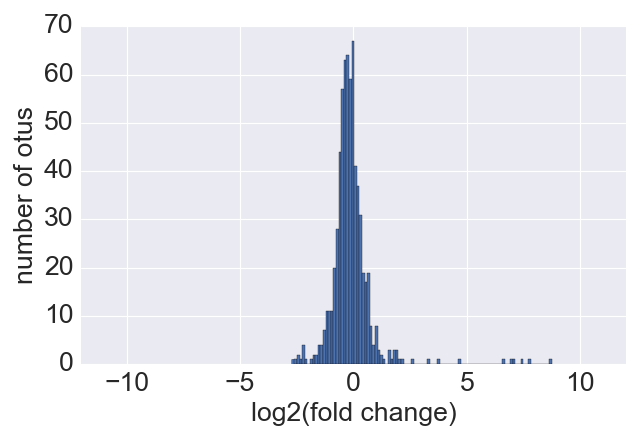

In [11]:
# mayo 4 days
mayo4fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 4',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

In [12]:
plt.savefig('../results/fig1-hist-mayo-4-0.pdf')

('241 Samples left',)
('92 Samples left',)
('75 Samples left',)
number of outliers (10 fold) 6
fraction of outliers (10 fold) 0.008915
mean abs log2 fold change 0.412695
median abs log2 fold change 0.276347


<IPython.core.display.Javascript object>


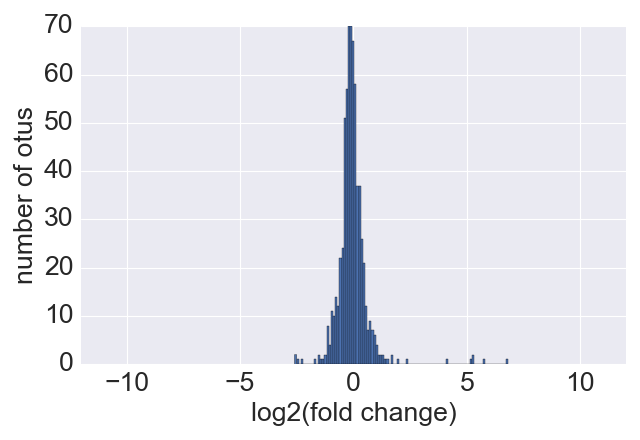

In [13]:
# mayo 1 day
mayo1fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 1',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

In [14]:
plt.savefig('../results/fig1-hist-mayo-1-0.pdf')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011527
mean abs log2 fold change 0.867410
median abs log2 fold change 0.713038


<IPython.core.display.Javascript object>


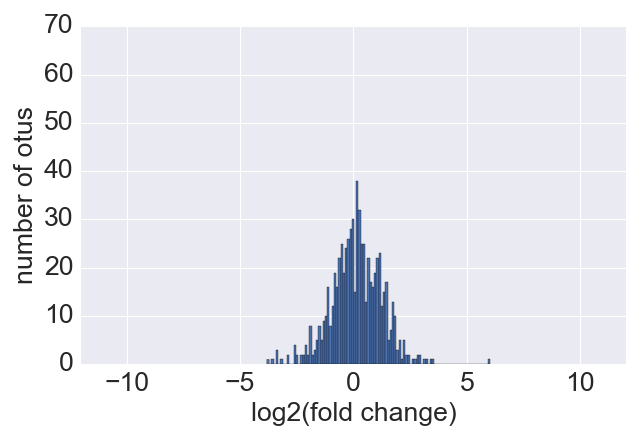

In [15]:
# se jin 1 week
sj7fc=teststability(sjf,time0val='1',time1val='2')

In [16]:
plt.savefig('../results/fig1-hist-sejin-7-0.pdf')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 39
fraction of outliers (10 fold) 0.051316
mean abs log2 fold change 1.234416
median abs log2 fold change 0.979320


<IPython.core.display.Javascript object>


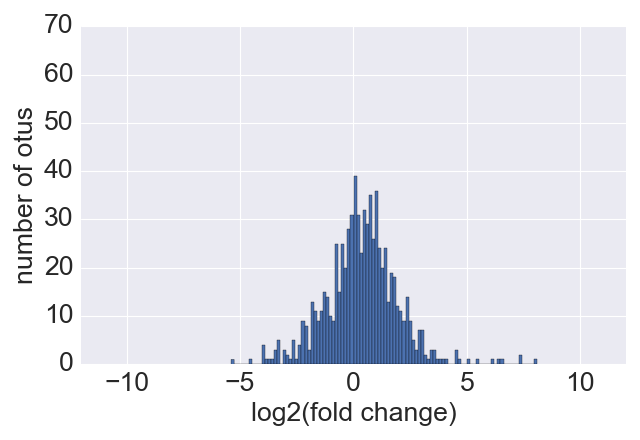

In [17]:
# se jin 2 weeks
sj14fc=teststability(sjf,time0val='1',time1val='3')

In [18]:
plt.savefig('../results/fig1-hist-sejin-14-0.pdf')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('30 Samples left',)
number of outliers (10 fold) 65
fraction of outliers (10 fold) 0.085526
mean abs log2 fold change 1.430598
median abs log2 fold change 1.107019


<IPython.core.display.Javascript object>


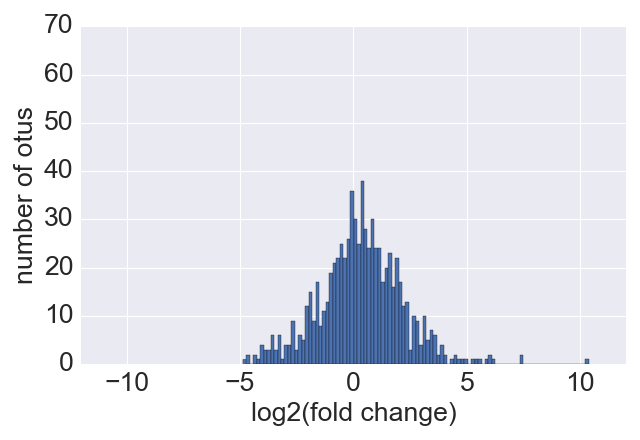

In [19]:
# se jin 4 weeks
sj28fc=teststability(sjf,time0val='1',time1val='4')

In [20]:
plt.savefig('../results/fig1-hist-sejin-28-0.pdf')

## differential expression
look how AG compares to the fresh frozen studies.
Join all studies together and find sOTUs sginificantly higher/lower in AG

In [21]:
# join tall the experiments to a single experiment
# the source experiment is stored in the field 'origexp'
fec=hs.joinexperiments(pgpf,twinsf)
fec=hs.joinexperiments(fec,ercf)
fec=hs.joinexperiments(fec,agf)

find differentially present bacteria in AG compared to all other experiments (joined) using permutation based mean difference (with BH-FDR 0.1)

We will identify differentially abundant microbes using a permutation mean difference test.  The test statistic will be conducted as follows

$abs(\bar{x_i} - \bar{y_i})$

where $\bar{x_i}$ represents the sample mean of sOTU $i$ in group $x$ and  $\bar{y_i}$ represents the sample mean of sOTU $i$ in group $y$.

The pvalue will be determined by repeated shuffling (1000 permutations) of the labels for groups $x$ and $y$ and recalculating this mean based on the new shuffled $x$ and $y$ groups.

An additional Benjamini-Hochberg FDR control at 0.1 is added to compensate for mutiple hypothesis testing (since the test is performed on a large number of sOTUs).

In [22]:
diff_ag_other=hs.diffexpfastpermute(fec,'origexp','ag-6-2016.clean.min100.withtax.biom')

('7073 Samples left',)
('1184 Samples left',)
cnumperm 100, numbact 369, numnotuse 22450
cnumperm 1000, numbact 369, numnotuse 22450


/Users/amnon/Python/git/heatsequer/heatsequer/utils/amnonutils.py:323: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  new_pvalues = np.empty(n)


## Calculate the fold change of american gut compared to all other experiments
For each sOTU, comapre the mean in all AG samples to the mean of all samples in a fresh-frozen experiment.

Note that since samples are not paired, we can just compare the means.

Comparison is calculated separately between AG and each fresh-frozen study (PGP, UK-Twins and Whole grain feces)

In [23]:
def get2expfc(exp1,exp2,minreads=1):
    """
    get the fold change for all bacteria in exp1/exp2
    
    input:
    exp1, exp2 : Experiment
        the experiments to comapre the sOTUs between
        (for all sOTUs in exp1)
    meanreads : float
        the minimal value of the mean reads per experiment (to reduce effect discretization)
    
    output:
    outfc : dict {sequence : foldchange}
        dict with sequences from exp1 ('ACGT') as keys, values are the mean(exp1)/mean(exp2)
    """
    outfc={}
    numnotfound=0
    
    # copy experiments so we don't change their data
    exp1=hs.copyexp(exp1)
    exp2=hs.copyexp(exp2)
    # iterate over all sequences in exp1
    for cseq in exp1.seqs:
        dat1=exp1.data[exp1.seqdict[cseq]]
        # if below minreads in exp1 - convert to minreads
        dat1[dat1<minreads]=minreads
        # if not present in exp2, convert it to minreads
        if cseq not in exp2.seqdict:
            numnotfound+=1
            dat2=np.ones(len(exp2.samples))*minreads
        else:
            dat2=exp2.data[exp2.seqdict[cseq]]
        # if below minreads in exp2 - convert to minreads
        dat2[dat2<minreads]=minreads
        # calculate the mean ratio
        fc=np.mean(dat1)/np.mean(dat2)
        outfc[cseq]=fc

    print('%d sequences not found' % numnotfound)
    return outfc

In [24]:
# fold change AG to PGP
fcpgp=get2expfc(agf,pgpf)

5262 sequences not found


In [25]:
# fold change AG to UK-Twins
fctwins=get2expfc(agf,twinsf)

6875 sequences not found


In [26]:
# fold change AG to Whole grains feces
fcerc=get2expfc(agf,ercf)

7739 sequences not found


# find the blooming bacteria list
intersect the ag-vs-others and the storage studies fold changes:

Iterate over all sOTUs which are significantly different between AG and all fresh-frozen samples.

For each such sOTU, we calculate two values:
1. The maximal growth potential (maximum over all storage studies and days)
2. The minimal ratio between AG to each fresh-frozen sample. The minimum is taken in order to reduce the effect of study-study differences (since a blooming bacteria is expected to be higher in AG compared to all fresh-frozen studies)

Candidate blooming bacteria are defined as sOTUs that have either:
- At least two fold difference in both (1) and (2), or that are not

OR
- At least two fold difference in (2) and are not present in (1) (since storage studies have a small set of individuals, there may be blooming bacteria that by chance were not present in the storage study samples)

OR
- At least 50 fold change in (1), so we know they can grow drastically in room temp.

In [33]:
# auxillary function to get minimal fold change for ag-fresh study comparison:
def GetAGFreshMin(cagfc,fresh_fc,cseq):
    """
    fold change to minimum(current fold change, ratio to fresh study)
    if was not present in fresh study, cap fold change to minimum(current fold change,50)

    input:
    cagfc : float
        the current minimal fold change of AG compared to all fresh frozen studies
    fresh_fc : dict of {sequence : foldchange}
        dict of fold change per sequence in the study (compared to AG)
    cseq : str ('ACGT' sequence)
        the sequence being analyzed
        
    output:
    cagfc : float
        the modified minimal fold change of AG compared to all fresh-frozen studies
    """
    if cseq in fresh_fc:
        cagfc=min(cagfc,fresh_fc[cseq])
    else:
        cagfc=min(cagfc,50)
    return cagfc


# auxillary function to get maximal fold change for storage studies day 0 comparison:
def GetStorageMax(maxfc,store_fc,cseq,readlen=0):
    """
    if we saw the sOTU in supplied storage study, fold change to maximum(current fold change,supplied storage study compared to day 0)
    
    input:
    maxfc : float
        the maximal fold change in all storage study/day compared to corresponding day 0
    store_fc : dict of {sequence : fold-change}
        dict of fold change per sequence in the storage study (compared to day 0)
    cseq : str ('ACGT' sequence)
        the sequence being analyzed
    readlen : int (optional)
        0 (default) to use full sequence length, otherwise use only readlen first bases
        used in Se-Jin storage study as reads were 124bp long
    
    output:
    maxfc : float
        the new maximal fold change in all storage study/day compared to corresponding day 0
    """
    # get the dict sequences read len (since one storage study is only 124bp)
#     readlen=len(next(iter(store_fc.keys())))
    if readlen>0:
        cseq=cseq[:readlen]
    if cseq in store_fc:
        maxfc=max(maxfc,store_fc[cseq])
    return maxfc

In [44]:
# find the new blooming bacteria list
# test the min of the ag vs other experiments (y axis) and the max growth (in storage studies) (x axis)
newbloom=[]
bloomscores=[]
bloomtax=[]

# x and y points for all and candidate blooming bacteria for the scatter plot
allx=[]
ally=[]
intx=[]
inty=[]
intsym=[]

# iterate over all sOTUs significantly different between AG to the other experiments
for idx,cseq in enumerate(diff_ag_other.seqs):
    # if didn't see it at all in AG sequences - skip it
    if cseq in agf.seqdict:
        # set the minimal fold change to very high number, so will go down with any fold change
        cagfc=1000000
    else:
        continue

    # calculate minimal fold change in AG compared to fresh frozen studies
    # PGP
    cagfc=GetAGFreshMin(cagfc,fcpgp,cseq)
    # UK-Twins
    cagfc=GetAGFreshMin(cagfc,fctwins,cseq)
    # Whole grain feces
    cagfc=GetAGFreshMin(cagfc,fcerc,cseq)

    # calculate maximal fold change (over days/studies) in storage studies (compare to time 0)
    
    # init maximal fold change to 0 (so any fold change is bigger)
    maxfc=0
    # if we saw the sOTU in mayo day 4, fold change to maximum(current fold change,mayo day 4 compared to 0)
    maxfc=GetStorageMax(maxfc,mayo1fc,cseq)
    maxfc=GetStorageMax(maxfc,mayo4fc,cseq)
    maxfc=GetStorageMax(maxfc,sj7fc,cseq,124)
    maxfc=GetStorageMax(maxfc,sj14fc,cseq,124)
    maxfc=GetStorageMax(maxfc,sj28fc,cseq,124)
    
    # if we have both fold changes for this sOTU, store it
    if maxfc>0 and cagfc>0:
        allx.append(maxfc)
        ally.append(cagfc)

    # test if this bacteria is a candidate blooming bacteria
    # the criteria when to call it a bloom is:
    # storage fold change>2 and AG fold change>2 or storage fold change>50 or AG fold change>2 and not observed in storage studies
    if (maxfc>2 and cagfc>2) or (maxfc>50) or (cagfc>2 and maxfc==0):
        print(diff_ag_other.tax[idx])
        print('agfc:%f, maxfc:%f' % (cagfc, maxfc))
        # add to candidate blooming list
        newbloom.append(cseq)
        bloomscores.append(maxfc)
        bloomtax.append(diff_ag_other.tax[idx])
        intx.append(maxfc)
        inty.append(cagfc)

print('total %d blooming bacteria' % len(newbloom))

Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Providencia;;
agfc:11.557930, maxfc:0.000000
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Morganella;;
agfc:2.660434, maxfc:122.471754
Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
agfc:2.457423, maxfc:0.000000
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;
agfc:2.930602, maxfc:0.000000
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Proteus;;
agfc:20.268196, maxfc:0.000000
Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;Lactobacillus;zeae;
agfc:2.574053, maxfc:4.218514
Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter;;
agfc:6.862510, maxfc:2.101859
Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Trabulsiella;farmeri;
agfc:17.805251, maxfc:221.818511
Bacteria;Firmicutes;Bacill

# Plot the fold change scatter plot KDE with highlighting the candidate blooming sOTUs
since we have a lot of sOTUs, each with max(storage fc) and min(ag-fresh fc), we plot the average densities of all sOTUs.

Red circles denote the sOTUs (15) passing the criteria for candidate blooming bacteria. Note that an additional set of 6 candidate blooming bacteria are not shown as they do not appear in the storage studies, and therefore do not have an x coordinate on the plot.

<IPython.core.display.Javascript object>


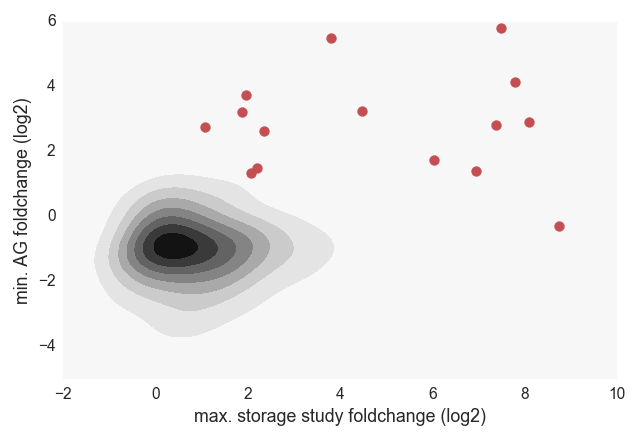

/Users/amnon/anaconda/envs/qt5test/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log2


In [40]:
plt.figure()
ax = plt.axes()
sn.kdeplot(np.log2(np.array(allx)),np.log2(np.array(ally)),shade=True, cmap='Greys', ax=ax)
plt.scatter(np.log2(np.array(intx)), np.log2(np.array(inty)), s=80, color=sn.color_palette()[2])
ax.set_xlim([-2, 10])
ax.set_ylim([-5, 6])
ax.set_xlabel('max. storage study foldchange (log2)',fontsize=16)
ax.set_ylabel('min. AG foldchange (log2)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

In [41]:
plt.savefig('../results/fig1-blooming-identification-kde.pdf')

## Sort the candidate blooming sOTUs by their storage study fold change
We want to order the candidate blooming sOTUs so the more likely/larger effect size bloomers are first.

We base the sort order on the storage study maximal fold change, as this approximates the potential for blooming, and the max over different storage times shows the growth in the more optimal conditions for each candidate bloomer (whereas the AG-fresh frozen fold change shows the mean blooming). This way, we give higher priority to sOTUs that can distort the most the frequencies (even if in a small number of samples).

In [42]:
# sort the blooming bacteria according to the maximal storage study fold change
sv,si=hs.isort(bloomscores,reverse=True)
newbloom=hs.reorder(newbloom,si)
bloomtax=hs.reorder(bloomtax,si)
bloomscores=hs.reorder(bloomscores,si)

In [43]:
# the sorted list of blooming bacteria
for idx,ctax in enumerate(bloomtax):
    print('%d : %f %s' % (idx,bloomscores[idx],ctax))

0 : 428.709868 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;
1 : 274.922735 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Citrobacter;;
2 : 221.818511 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Trabulsiella;farmeri;
3 : 178.543915 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;fragi;
4 : 165.392345 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Escherichia;coli;
5 : 122.471754 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Morganella;;
6 : 65.534354 Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;;;
7 : 22.295722 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Klebsiella;;
8 : 13.993001 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
9 : 5.096785 Bacteria;Proteobacteria;Gammaproteoba

## save the bloom sequences

In [45]:
hs.saveseqsfasta(agf,newbloom,'../data/newbloom.all.fa')

In [46]:
hs.saveseqsfasta(agf,newbloom[:8],'../data/newbloom.8.fa')

# Plot the taxonomy comparison before and after bloom filtering

## prepare the joined experiment

In [47]:
# join AG and PGP
allf=hs.joinexperiments(agf,pgpf)

In [48]:
# remove the AG mapping fields (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

In [49]:
# join the UK-Twins
allf=hs.joinexperiments(allf,twinsf)

In [50]:
# and join the Whole grain feces
allf=hs.joinexperiments(allf,ercf)

In [51]:
# remove all mapping fields except 'origexp' (the original study) (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

## Plot the pre-filtered taxonomy plot

In [52]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpre=hs.filtersimilarsamples(allf,'origexp',method='mean')

('8257 samples before filtering, 4 after',)


In [53]:
# sort by original experiment
allfpre=hs.sortsamples(allfpre,'origexp')

In [54]:
hs.getfieldvals(allfpre,'origexp')

['ag-6-2016.clean.min100.withtax.biom',
 'ercolini.feces.clean.withtax.biom',
 'pgp.baylor.clean.withtax.biom',
 'twins2.clean.min10.withtax.biom']

In [55]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpre,'expname',['AG-pre','EWF-pre','PGP-pre','UKTwins-pre'])

In [56]:
sn.set_style("white")

<IPython.core.display.Javascript object>


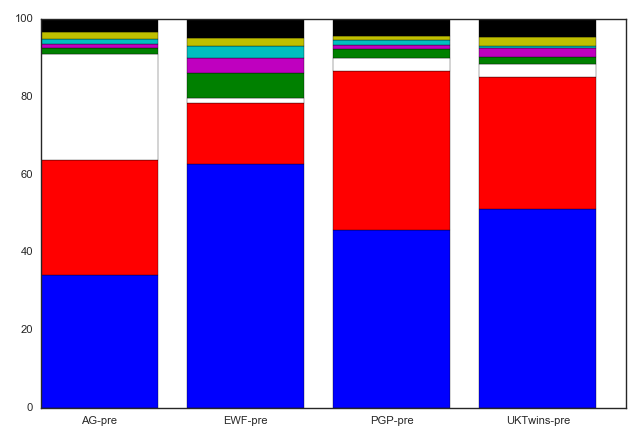

In [57]:
# plot the taxonomy bar graph (normalized to 100% per study)
taxlist=hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True)

In [58]:
plt.savefig('../results/fig2C_taxonomy-4exp-nofiltering.pdf')

## plot the post-filtering taxonomy plot

In [59]:
# filter the 8 blooming bacteria
allfpost=hs.filterseqs(allf,newbloom[:8],exclude=True)

In [60]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpost=hs.filtersimilarsamples(allfpost,'origexp',method='mean')

('8257 samples before filtering, 4 after',)


In [61]:
# sort by original experiment
allfpost=hs.sortsamples(allfpost,'origexp')

In [62]:
hs.getfieldvals(allfpost,'origexp')

['ag-6-2016.clean.min100.withtax.biom',
 'ercolini.feces.clean.withtax.biom',
 'pgp.baylor.clean.withtax.biom',
 'twins2.clean.min10.withtax.biom']

In [63]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpost,'expname',['AG-post','EWF-post','PGP-post','UKTwins-post'])

In [64]:
sn.set_style("white",{'legend.frameon':True})
sn.set_context("notebook")

<IPython.core.display.Javascript object>


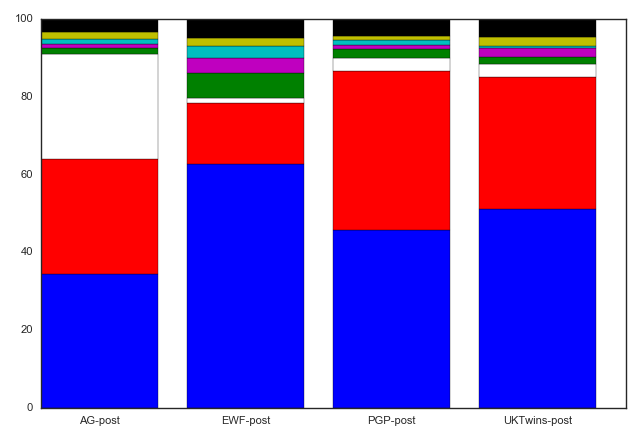

In [65]:
# plot the taxonomy bar graph (normalized to 100% per study). Use same phylum order as previous taxonomy plot
hs.plottaxonomybar(allfpost,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True,taxorder=taxlist.tax)

In [66]:
plt.savefig('../results/fig2C_taxonomy-4exp-withfiltering-8.pdf')

## and for the legend

<IPython.core.display.Javascript object>


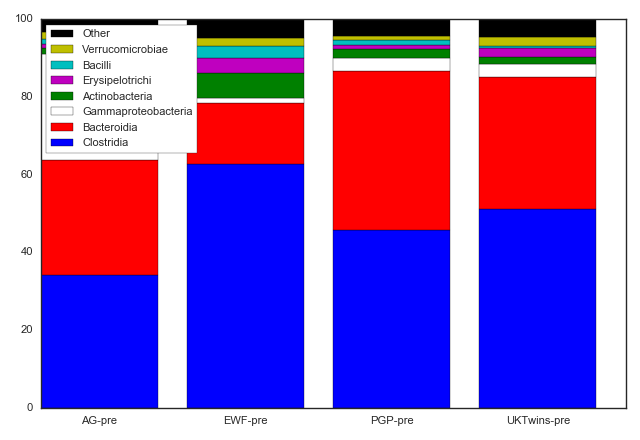

In [67]:
# plot with legend (we just cut out the legend in the figure)
hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=True,showxlabels=True,rotation=0,sumone=True)

In [68]:
plt.savefig('../results/fig2C_taxonomy-4exp-forlegend.pdf')

In conclusion, we can take advantage of the microbes identified to be blooming in previous studies, combined with comparison between shipped and fresh frozen samples, to identify candidate taxa that bloom in storage conditions in the American Gut project.

An advantage of performing such analysis on a sub-OTU level (i.e. the output of the Deblur algorithm), is that we can identify and remove the exact blooming bacterial sequences, whereas using traditional OTU based methods would require removal of the blooming bacteria and all close sequences, which can lead to much higher numbers of bacteria removed.

Note that choosing the number of candidate blooming bacteria to remove is a type-1/type-2 balance. Removal of more bacteria will reduce the effect of shipment, at the cost of losing more bacteria for analysis.

While all bacteria may change during shipment, it seems only a small number of them exhibit a drastic growth. By removal of as little as the top 8 blooming bacteria, we can greatly reduce the effect of shipment. This leads to a great reduction in the noise within American Gut samples (since not all samples are undergo the same shipment conditions/duration), as well as enable comparison to other, fresh frozen studies.
